# Make graph data

In [56]:
import numpy as np
import pandas as pd
import time
import math

import torch
import torch.nn as nn
from torch.utils.data.dataset import random_split
from torch.optim import lr_scheduler

In [57]:
def get_feature(graph_atoms):
    N = len(graph_atoms)
    for i in range(N):
        graph_atoms[i] = atom2vec[graph_atoms[i]]
    return np.array(graph_atoms)

In [90]:
def get_dist(crd1, crd2):
    crd1 = np.array(crd1)
    crd2 = np.array(crd2)
    return np.linalg.norm(crd1-crd2)

def get_adj(graph_crd):
    N = len(graph_crd)
    adj = np.ones([N,N])*0.5
    for i in range(N):
        for j in range(N):
            if i!=j:
                adj[i][j]=1/get_dist(graph_crd[i],graph_crd[j])
    return adj

In [91]:
atoms_loc_data = pd.read_csv('O_atom_location.csv')
atoms_loc_data['coord'] = [tuple(row[col] for col in ['x', 'y', 'z']) for _, row in atoms_loc_data.iterrows()]
atoms_loc_data = atoms_loc_data.drop('x', axis=1)
atoms_loc_data = atoms_loc_data.drop('y', axis=1)
atoms_loc_data = atoms_loc_data.drop('z', axis=1)
atom2vec = pd.read_csv('atom2vec_SVD20.csv', index_col=0).T
energy_data = list(pd.read_csv('mat_energy.csv')['energy'])

In [92]:
graph_data = []
for i in range(max(set(atoms_loc_data['num']))):
    nodes = get_feature(list(atoms_loc_data[atoms_loc_data['num']==i+1]['atom']))
    adj = get_adj(list(atoms_loc_data[atoms_loc_data['num']==i+1]['coord']))
    energy = energy_data[i]
    if energy > 0:
        graph_data.append([nodes, adj, energy])
##### graph_data[idx][0] => N*D feature matrix
##### graph_data[idx][1] => N*N adjacency matrix
##### graph_data[idx][2] => 1 energy

In [93]:
graph_data = []
for i in range(int(len(set(atoms_loc_data['num']))/4)):
    min_idx = np.argmin(energy_data[i*4:(i+1)*4])
    idx = 4*i + min_idx
    nodes = get_feature(list(atoms_loc_data[atoms_loc_data['num']==idx+1]['atom']))
    adj = get_adj(list(atoms_loc_data[atoms_loc_data['num']==idx+1]['coord']))
    energy = energy_data[idx]
    if energy > 0:
        graph_data.append([nodes, adj, energy])

In [96]:
torch.manual_seed(0)
num_of_data = len(graph_data)
num_of_train = int(len(graph_data)*0.8)
num_of_test = len(graph_data)-num_of_train
print (num_of_data, num_of_train, num_of_test)
train_data, test_data = random_split(graph_data, [num_of_train, num_of_test])

308 246 62


# Grpah NN

In [97]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, init):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(batch_size, in_features, out_features))
        #self.bias = nn.Parameter(torch.FloatTensor(batch_size, out_features))

        if init == 'uniform':
            print("| Uniform Initialization")
            self.reset_parameters_uniform()
        elif init == 'xavier':
            print("| Xavier Initialization")
            self.reset_parameters_xavier()
        elif init == 'kaiming':
            print("| Kaiming Initialization")
            self.reset_parameters_kaiming()
        else:
            raise NotImplementedError

    def reset_parameters_uniform(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        #self.bias.data.uniform_(-stdv, stdv)

    def reset_parameters_xavier(self):
        nn.init.xavier_normal_(self.weight.data, gain=0.02) # Implement Xavier Uniform
        #nn.init.constant_(self.bias.data, 0.0)

    def reset_parameters_kaiming(self):
        nn.init.kaiming_normal_(self.weight.data, a=0, mode='fan_in')
        #nn.init.constant_(self.bias.data, 0.0)

    def forward(self, input, adj):
        output = torch.bmm(adj, torch.bmm(input, self.weight))
        return output

In [133]:
class GCN(nn.Module):
    def __init__(self, nfeat, nclass, init):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, 20, init=init)
        self.act1 = nn.ReLU()
        self.gc2 = GraphConvolution(20, 20, init=init)
        self.act2 = nn.ReLU()
        self.gc3 = GraphConvolution(20, nclass, init=init)

    def forward(self, x, adj):
        x1 = self.act1(self.gc1(x, adj))+x
        x2 = self.act2(self.gc2(x1, adj))+x+x1
        x3 = self.gc3(x2, adj)
        output = torch.mean(x3, dim=1).view(batch_size)
        return output

# Train

In [134]:
# Hyper Parameters 
num_epochs = 10000
batch_size = int(num_of_data*0.1)+1
learning_rate = 1e-4

criterion = nn.SmoothL1Loss()

In [135]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [136]:
# train
def fit(model,train_loader,criterion,learning_rate,num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-6)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=int(num_epochs/2), gamma=0.1)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss=0
        for i, data in enumerate(train_loader):
            features = data[0].type(torch.FloatTensor).cuda(0)
            adj = data[1].type(torch.FloatTensor).cuda(0)
            energy = data[2].type(torch.FloatTensor).cuda(0)
            
            optimizer.zero_grad()
            output = model(features, adj)
            
            loss = criterion(output, energy)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            features = features.cpu()
            adj = adj.cpu()
            energy = energy.cpu()

        if epoch==0 or (epoch+1)%1000 == 0:
            print ("Epoch [%d/%d], train loss avg : %.4f" % (epoch+1, num_epochs, epoch_loss/len(train_loader)))
            curr_lr = optimizer.param_groups[0]['lr']
            print('Learning rate : {}\n'.format(curr_lr))
        scheduler.step()
        # file_name = './model/'+model_name+'/epoch{}.pth'.format(epoch+1)
        # torch.save(model.state_dict(), file_name)

In [137]:
model = GCN(20, 1, 'uniform').cuda(0)
start_time = time.time()

fit(model, train_loader, criterion, learning_rate, num_epochs)
print ("--- %s seconds ---" % (time.time() - start_time))

| Uniform Initialization
| Uniform Initialization
| Uniform Initialization
Epoch [1/10000], train loss avg : 0.9313
Learning rate : 0.0001

Epoch [1000/10000], train loss avg : 0.0324
Learning rate : 0.0001

Epoch [2000/10000], train loss avg : 0.0225
Learning rate : 0.0001

Epoch [3000/10000], train loss avg : 0.0170
Learning rate : 0.0001

Epoch [4000/10000], train loss avg : 0.0150
Learning rate : 0.0001

Epoch [5000/10000], train loss avg : 0.0118
Learning rate : 0.0001

Epoch [6000/10000], train loss avg : 0.0096
Learning rate : 1e-05

Epoch [7000/10000], train loss avg : 0.0106
Learning rate : 1e-05

Epoch [8000/10000], train loss avg : 0.0111
Learning rate : 1e-05

Epoch [9000/10000], train loss avg : 0.0110
Learning rate : 1e-05

Epoch [10000/10000], train loss avg : 0.0105
Learning rate : 1e-05

--- 69.21545910835266 seconds ---


In [142]:
# eval
def eval(model,test_loader):
    model.eval()
    pred_all = []
    real_all = []

    for i, data in enumerate(test_loader):
        features = data[0].type(torch.FloatTensor).cuda(0)
        adj = data[1].type(torch.FloatTensor).cuda(0)
        energy = data[2].type(torch.FloatTensor).cuda(0)
        real_all += list(energy.cpu().detach().numpy())
        
        pred_energy = model(features, adj)
        pred_energy = list(pred_energy.cpu().detach().numpy())
        pred_all += pred_energy

    real_all = np.array(real_all)
    pred_all = np.array(pred_all)
    l1_loss = np.abs(real_all-pred_all).mean(axis=0)
    print (l1_loss)
    return real_all, pred_all

In [146]:
real_all, pred_all = eval(model, test_loader)

0.186201


---

In [147]:
import matplotlib.pyplot as plt

(-0.1391143394322574, 2.8490436901958169)

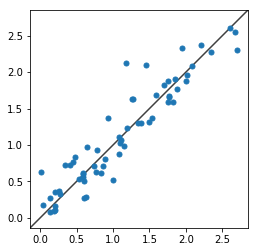

In [148]:
fig, ax = plt.subplots()
ax.scatter(real_all, pred_all, s=25)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)